# First part


In [ ]:
import os
import PyPDF2
import pdfplumber

def extract_text_from_pdfs(folder_path):
    pdf_texts = {}
    
    # Iterate through all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.pdf'):
            file_path = os.path.join(folder_path, file_name)
            
            # Open the PDF file
            with open(file_path, 'rb') as pdf_file:
                # Extract text using PyPDF2
                pdf_reader = PyPDF2.PdfReader(pdf_file)  # Updated class
                text = ""
                for page_num in range(len(pdf_reader.pages)):  # Accessing pages
                    page = pdf_reader.pages[page_num]
                    text += page.extract_text()

                # Store text in dictionary with filename as key
                pdf_texts[file_name] = text
    
    return pdf_texts

# Example usage
folder_path = "Resume"
pdf_texts = extract_text_from_pdfs(folder_path)

# Now you can process the extracted text (e.g., NLP analysis)
for file_name, text in pdf_texts.items():
    print(f"Text from {file_name}:\n{text[:500]}")  # Display first 500 characters of each resume


In [2]:
import re

def clean_text(text):
    # Remove newline characters, special symbols, and extra spaces
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.lower().strip()

def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText)
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText

# Apply the function to your extracted texts
pdf_texts_cleaned = {file_name: cleanResume(text) for file_name, text in pdf_texts.items()}



In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def plot_elbow_method(X, max_clusters=10):
    wcss = []
    for i in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    
    # Plot the elbow graph
    plt.plot(range(1, max_clusters+1), wcss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

# Example usage with your TF-IDF matrix (X_tfidf)
plot_elbow_method(X_tfidf)


In [ ]:
import os
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Function to clean text
def clean_text(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText)
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText

# Extract text from PDFs (this part should already be done)
folder_path = "Resume"
pdf_texts_cleaned = {file_name: clean_text(text) for file_name, text in pdf_texts.items()}

# Convert text to list for TF-IDF vectorization
documents = list(pdf_texts_cleaned.values())

# Step 1: Create TF-IDF Matrix
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)  # You can adjust 'max_features'
X_tfidf = vectorizer.fit_transform(documents)

# Step 2: Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out(), index=pdf_texts_cleaned.keys())

# Step 3: Apply K-Means Clustering
num_clusters = 2  # You can set the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
tfidf_df['cluster'] = kmeans.fit_predict(X_tfidf)

# Display the DataFrame
print(tfidf_df.head())

# Example: View CVs by cluster
for cluster_num in range(num_clusters):
    print(f"\nCluster {cluster_num}:")
    print(tfidf_df[tfidf_df['cluster'] == cluster_num].index.tolist())


In [ ]:
# import os
# import shutil
# 
# def export_clustered_cvs(folder_path, cv_filenames, cluster_labels):
#     """
#     Export CVs into folders based on their cluster assignments.
# 
#     :param folder_path: Path to the folder containing the original CVs.
#     :param cv_filenames: List of filenames of the CVs.
#     :param cluster_labels: List of cluster labels corresponding to each CV.
#     """
#     # Ensure base folder exists
#     if not os.path.exists(folder_path):
#         print(f"The folder '{folder_path}' does not exist.")
#         return
#     
#     # Create a dictionary of clusters
#     clusters = {}
#     for i, label in enumerate(cluster_labels):
#         if label not in clusters:
#             clusters[label] = []
#         clusters[label].append(cv_filenames[i])
# 
#     # Create cluster folders and move files into them
#     for cluster, files in clusters.items():
#         # Create a subfolder for each cluster
#         cluster_folder = os.path.join(folder_path, f'Cluster_{cluster}')
#         os.makedirs(cluster_folder, exist_ok=True)
#         
#         for file_name in files:
#             source_file = os.path.join(folder_path, file_name)
#             destination_file = os.path.join(cluster_folder, file_name)
#             
#             # Move the file into the appropriate cluster folder
#             shutil.move(source_file, destination_file)
#             print(f"Moved {file_name} to {cluster_folder}")
# 
# # Example usage
# folder_path = "Resume"  # Path to the folder where CVs are stored
# cv_filenames = os.listdir(folder_path)  # List of all the filenames (make sure these are the actual CV files)
# cluster_labels = kmeans.labels_  # Assuming you used KMeans and have labels from the model
# 
# export_clustered_cvs(folder_path, cv_filenames, cluster_labels)
# 

# Second part 

In [1]:
import os
import PyPDF2
import pdfplumber

In [5]:
api_key = "sk-LXBpYK9Dtdk5DMPbbAVqiNlfVO2R8qz8aZGvrsGC-kT3BlbkFJx18GrbnxooP2K0XKtr880pcIMYiUCb20eCBj3fPnIA"

In [6]:
import openai
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Initialize OpenAI API with your key
openai.api_key = api_key  # Replace with your OpenAI or Azure OpenAI key

# Function to get embeddings using the new OpenAI API
def get_embedding(text, model="text-embedding-ada-002"):
    response = openai.embeddings.create(
        input=[text],  # input should now be a list of strings
        model=model
    )
    return response['data'][0]['embedding']

# Sample dataframe of candidates (replace this with your own extracted dataframe)
data = {
    "Name": ["Alice Johnson", "Bob Smith", "Charlie Rose"],
    "Email": ["alice@example.com", "bob@example.com", "charlie@example.com"],
    "Skills": ["Python, Machine Learning, Data Analysis", 
               "Project Management, Agile, Scrum", 
               "Java, Spring Boot, Microservices"],
    "Education": ["MIT, Computer Science", "Stanford, MBA", "Harvard, Software Engineering"],
    "Experience": ["5 years in software development", "8 years in project management", "6 years in backend development"]
}

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Job description for comparison
job_description = "We are looking for a software engineer with experience in Python, Machine Learning, and Data Analysis."

# Get embedding for the job description
job_embedding = get_embedding(job_description)

# Get embeddings for each candidate's relevant data (Skills, Education, and Experience combined)
df['Resume_Embedding'] = df.apply(lambda row: get_embedding(f"{row['Skills']}. {row['Education']}. {row['Experience']}."), axis=1)

# Calculate cosine similarity between the job description and each candidate
df['Similarity_Score'] = df['Resume_Embedding'].apply(lambda x: cosine_similarity([job_embedding], [x]).flatten()[0])

# Sort candidates by similarity score (highest first)
df_sorted = df.sort_values(by='Similarity_Score', ascending=False)

# Print the ranked candidates
print(df_sorted[['Name', 'Email', 'Similarity_Score']])


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [7]:
import spacy

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Text preprocessing function
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    return tokens

job_description = "We are looking for a software engineer with experience in Python, Machine Learning, and Data Analysis."
preprocessed_job_desc = preprocess_text(job_description)


In [6]:
import os
import json
import pandas as pd
import re

# Function to extract relevant information from a single JSON file
def extract_resume_data(json_data):
    try:
        # Extract the content from the JSON (may need to adjust based on actual structure)
        content = json_data.get('analyzeResult', {}).get('content', '')
        
        # Extract personal information (name, email)
        name = extract_name(content)
        email = extract_email(content)
        
        # Extract technical skills section
        technical_skills = extract_section(content, "SUMMARY OF TECHNICAL SKILLS", "EDUCATION")
        
        # Extract education
        education = extract_section(content, "EDUCATION", "RELATED EXPERIENCE")
        
        # Extract experience
        experience = extract_section(content, "RELATED EXPERIENCE", "LEADERSHIP AND AFFILIATIONS")
        
        return {
            "Name": name,
            "Email": email,
            "Technical_Skills": technical_skills,
            "Education": education,
            "Experience": experience
        }
    except Exception as e:
        print(f"Error extracting data: {e}")
        return None

# Helper function to extract name (adjust based on patterns in the resume)
def extract_name(content):
    lines = content.split("\n")
    for line in lines:
        # Attempt to extract name (assume name appears in the first few lines)
        if line.strip() and "@" not in line:  # Avoid email lines
            return line.strip()
    return None

# Helper function to extract email (basic regex match for email)
def extract_email(content):
    email_match = re.search(r'[\w\.-]+@[\w\.-]+', content)
    return email_match.group(0) if email_match else None

# Helper function to extract sections of the resume between headers
def extract_section(content, start_keyword, end_keyword):
    try:
        start_idx = content.find(start_keyword)
        end_idx = content.find(end_keyword, start_idx) if start_idx != -1 else -1
        if start_idx != -1 and end_idx != -1:
            return content[start_idx:end_idx].strip()
        elif start_idx != -1:
            return content[start_idx:].strip()  # Return everything after start_keyword if end not found
    except Exception as e:
        print(f"Error extracting section {start_keyword}: {e}")
    return None

# Function to process all JSON files in the folder
def process_json_files(folder_path):
    resume_data_list = []
    
    # Loop through all JSON files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as json_file:
                json_data = json.load(json_file)
                resume_data = extract_resume_data(json_data)
                if resume_data:
                    resume_data_list.append(resume_data)
    
    # Create a DataFrame from the extracted data
    df_resumes = pd.DataFrame(resume_data_list)
    return df_resumes

# Path to the folder containing JSON files
folder_path = "csResume"  # Update with the actual folder path

# Process all JSON files and create a DataFrame
df_resumes = process_json_files(folder_path)

# Save the DataFrame to a CSV file (optional)
df_resumes.to_csv('resumes_extracted.csv', index=False)

# Display the DataFrame
print(df_resumes)


                   Name                  Email  \
0    FIRSTNAME LASTNAME    tstudent@towson.edu   
1  Resume 4: Emily Wong  emilywong@example.com   
2             YOUR NAME                   None   
3       Name: James Lee                   None   
4  Resume 1: John Smith  johnsmith@example.com   
5       U.X. (Dee) Sign         uxsi@gmail.com   

                                    Technical_Skills  \
0  SUMMARY OF TECHNICAL SKILLS\nÂ· Languages: ASP...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   
5                                               None   

                                           Education  \
0  EDUCATION\nMaster of Science, Computer Science...   
1                                               None   
2  EDUCATION\nSoutheastern Louisiana University (...   
3                               

In [1]:
import os
import json
import pandas as pd

# Function to extract relevant information from a single JSON file
def extract_resume_data(json_data):
    try:
        # Extract the raw content (adjust as per your needs)
        content = json_data['analyzeResult']['content']
        
        # Extract personal information (example: name, email from content)
        name = extract_name(content)
        email = extract_email(content)
        
        # Extract technical skills section (search for relevant keywords)
        technical_skills = extract_technical_skills(content)
        
        # Extract education (you can search for "EDUCATION" keyword in content)
        education = extract_education(content)
        
        # Extract experience (you can search for "EXPERIENCE" or related keywords)
        experience = extract_experience(content)
        
        return {
            "Name": name,
            "Email": email,
            "Technical_Skills": technical_skills,
            "Education": education,
            "Experience": experience
        }
    except Exception as e:
        print(f"Error extracting data: {e}")
        return None

# Helper function to extract name (adjust based on patterns in the resume)
def extract_name(content):
    lines = content.split("\n")
    for line in lines:
        if "FIRSTNAME" in line:  # Example placeholder
            return line.strip()
    return None

# Helper function to extract email (basic regex match for email)
import re
def extract_email(content):
    email_match = re.search(r'[\w\.-]+@[\w\.-]+', content)
    return email_match.group(0) if email_match else None

# Helper function to extract technical skills (adjust based on patterns)
def extract_technical_skills(content):
    start_idx = content.find("SUMMARY OF TECHNICAL SKILLS")
    end_idx = content.find("EDUCATION", start_idx) if start_idx != -1 else -1
    if start_idx != -1 and end_idx != -1:
        return content[start_idx:end_idx].strip()
    return None

# Helper function to extract education
def extract_education(content):
    start_idx = content.find("EDUCATION")
    end_idx = content.find("RELATED EXPERIENCE", start_idx) if start_idx != -1 else -1
    if start_idx != -1 and end_idx != -1:
        return content[start_idx:end_idx].strip()
    return None

# Helper function to extract experience
def extract_experience(content):
    start_idx = content.find("RELATED EXPERIENCE")
    end_idx = content.find("LEADERSHIP AND AFFILIATIONS", start_idx) if start_idx != -1 else -1
    if start_idx != -1 and end_idx != -1:
        return content[start_idx:end_idx].strip()
    return None

# Function to process all JSON files in the folder
def process_json_files(folder_path):
    resume_data_list = []
    
    # Loop through all JSON files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as json_file:
                json_data = json.load(json_file)
                resume_data = extract_resume_data(json_data)
                if resume_data:
                    resume_data_list.append(resume_data)
    
    # Create a DataFrame from the extracted data
    df_resumes = pd.DataFrame(resume_data_list)
    return df_resumes

# Path to the folder containing JSON files
folder_path = "csResume"  # Update with the actual folder path

# Process all JSON files and create a DataFrame
df_resumes = process_json_files(folder_path)

# Save the DataFrame to a CSV file (optional)
"df_resumes.to_csv('resumes_extracted.csv', index=False)"

# Display the DataFrame
print(df_resumes)


                 Name                  Email  \
0  FIRSTNAME LASTNAME    tstudent@towson.edu   
1                None  emilywong@example.com   
2                None                   None   
3                None                   None   
4                None  johnsmith@example.com   
5                None         uxsi@gmail.com   

                                    Technical_Skills  \
0  SUMMARY OF TECHNICAL SKILLS\nÂ· Languages: ASP...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   
5                                               None   

                                           Education  \
0  EDUCATION\nMaster of Science, Computer Science...   
1                                               None   
2  EDUCATION\nSoutheastern Louisiana University (...   
3                                             

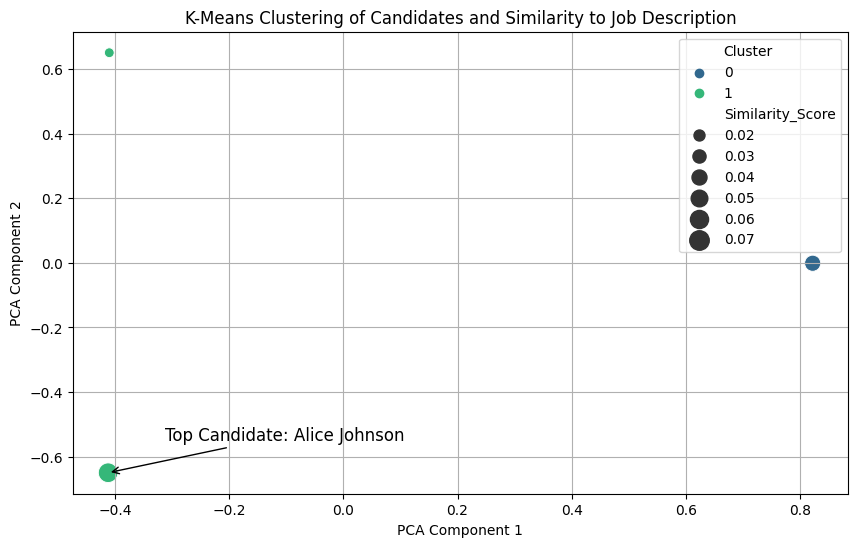

            Name                Email  Similarity_Score
0  Alice Johnson    alice@example.com          0.071087
1      Bob Smith      bob@example.com          0.046873
2   Charlie Rose  charlie@example.com          0.015205


In [11]:
import pandas as pd
import numpy as np
import PyPDF2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Function to extract text from PDF (Job Description)
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page in reader.pages:
            text += page.extract_text()
    return text

# Load the job description from PDF

job_description_pdf = "job_description.pdf"
job_description = extract_text_from_pdf(job_description_pdf)

# Sample DataFrame of candidates 
data = {
    "Name": ["Alice Johnson", "Bob Smith", "Charlie Rose"],
    "Email": ["alice@example.com", "bob@example.com", "charlie@example.com"],
    "Skills": [
        "Python, Machine Learning, Data Analysis",
        "Project Management, Agile, Scrum",
        "Java, Spring Boot, Microservices"
    ],
    "Education": [
        "MIT, Computer Science",
        "Stanford, MBA",
        "Harvard, Software Engineering"
    ],
    "Experience": [
        "5 years in software development",
        "8 years in project management",
        "6 years in backend development"
    ]
}

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Combine the candidate information into a single text field
df['Resume_Text'] = df['Skills'] + ". " + df['Education'] + ". " + df['Experience']

# Add the job description as a comparison point
corpus = df['Resume_Text'].tolist()
corpus.append(job_description)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus)

# Exclude the last entry (job description) for clustering
X_resumes = X[:-1]  # All resumes
job_vector = X[-1]  # Job description

# Perform K-Means Clustering 
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_resumes)

# Add the cluster labels to the DataFrame
df['Cluster'] = kmeans.labels_

# Reduce dimensionality for visualization using PCA (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resumes.toarray())

# Add PCA coordinates to DataFrame
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Cosine similarity with the job description
df['Similarity_Score'] = cosine_similarity(X_resumes, job_vector).flatten()

# Sort candidates by similarity score (highest to lowest)
df_sorted = df.sort_values(by='Similarity_Score', ascending=False)

# Visualization of Clustering and Similarity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', size='Similarity_Score', sizes=(50, 200), data=df_sorted, palette='viridis', legend='brief')

# Highlight the top candidate with an annotation
top_candidate = df_sorted.iloc[0]
plt.annotate(f"Top Candidate: {top_candidate['Name']}", xy=(top_candidate['PCA1'], top_candidate['PCA2']), 
             xytext=(top_candidate['PCA1']+0.1, top_candidate['PCA2']+0.1),
             arrowprops=dict(facecolor='black', arrowstyle="->"), fontsize=12)

plt.title('K-Means Clustering of Candidates and Similarity to Job Description')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Print sorted candidates by similarity
print(df_sorted[['Name', 'Email', 'Similarity_Score']])


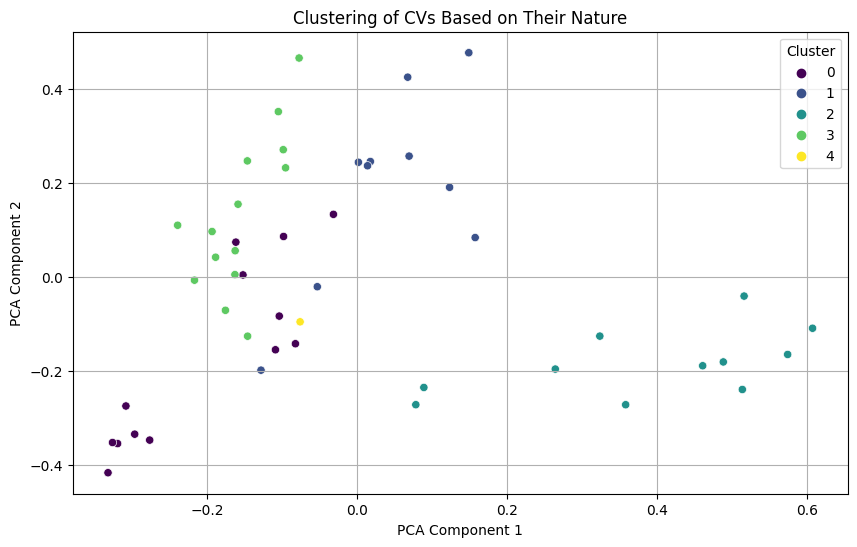

                                  filename  Cluster
0                                as(1).pdf        2
1                                as(2).pdf        4
2                                as(3).pdf        2
3                                as(4).pdf        2
4                                as(5).pdf        2
5                                as(6).pdf        2
6                                as(7).pdf        2
7                                as(8).pdf        2
8                                   as.pdf        2
9                    Basic_Resume.docx.pdf        0
10                Business_Resume.docx.pdf        0
11                               cs(1).pdf        3
12                              cs(10).pdf        3
13                              cs(11).pdf        0
14                              cs(12).pdf        3
15                              CS(13).pdf        3
16                              cs(14).pdf        3
17                              cs(15).pdf        0
18          

In [13]:
import os
import PyPDF2
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import docx

# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page in reader.pages:
            text += page.extract_text()
    return text

# Function to extract text from DOCX
def extract_text_from_docx(docx_path):
    doc = docx.Document(docx_path)
    return "\n".join([para.text for para in doc.paragraphs])

# Load all resumes from a folder (PDF and DOCX)
def load_resumes_from_folder(folder_path):
    resumes = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith(".pdf"):
            text = extract_text_from_pdf(file_path)
        elif filename.endswith(".docx"):
            text = extract_text_from_docx(file_path)
        else:
            continue
        resumes.append({"filename": filename, "text": text})
    return pd.DataFrame(resumes)

# Load resumes from the folder
folder_path = "Resume"
df_resumes = load_resumes_from_folder(folder_path)

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df_resumes['text'])

# K-Means Clustering (choose the number of clusters)
num_clusters = 5  # Adjust this based on the nature of the CVs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_resumes['Cluster'] = kmeans.fit_predict(X)

# Dimensionality reduction using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Add PCA results to the DataFrame
df_resumes['PCA1'] = X_pca[:, 0]
df_resumes['PCA2'] = X_pca[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_resumes, palette='viridis', legend='full')
plt.title('Clustering of CVs Based on Their Nature')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

# Output the clustered resumes for inspection
print(df_resumes[['filename', 'Cluster']])


    filename                                               text
0  as(1).pdf  Name: Sarah Williams  \nEducation:  \n \nBSc i...
1  as(2).pdf  F\nI R S T\nL\nA S T\nL i t t l e  R o c k ,  ...
2  as(3).pdf  Resume 4: Michael Brown  \nContact Information...
3  as(4).pdf  ACTUARIAL SCIENCE  - Revised Aug. 201 4 \nThe ...
4  as(5).pdf  F i r s t  L a s t\nActuarial Manager\nMadison...


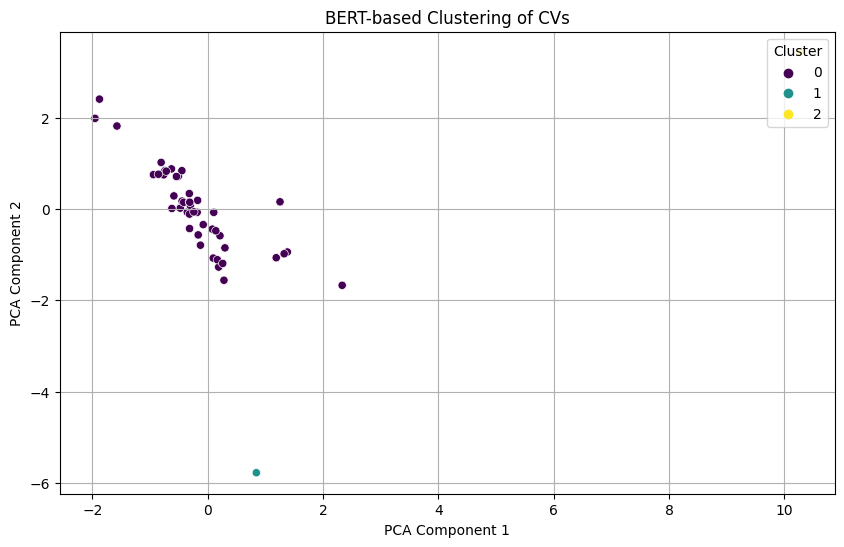

                                  filename  Cluster
0                                as(1).pdf        0
1                                as(2).pdf        2
2                                as(3).pdf        0
3                                as(4).pdf        0
4                                as(5).pdf        0
5                                as(6).pdf        0
6                                as(7).pdf        0
7                                as(8).pdf        0
8                                   as.pdf        0
9                    Basic_Resume.docx.pdf        0
10                Business_Resume.docx.pdf        0
11                               cs(1).pdf        0
12                              cs(10).pdf        0
13                              cs(11).pdf        0
14                              cs(12).pdf        0
15                              CS(13).pdf        0
16                              cs(14).pdf        0
17                              cs(15).pdf        0
18          

In [2]:
import os
import PyPDF2
import docx
import pandas as pd

# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page in reader.pages:
            text += page.extract_text()
    return text

# Function to extract text from DOCX
def extract_text_from_docx(docx_path):
    doc = docx.Document(docx_path)
    return "\n".join([para.text for para in doc.paragraphs])

# Load all resumes from a folder (PDF and DOCX)
def load_resumes_from_folder(folder_path):
    resumes = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith(".pdf"):
            text = extract_text_from_pdf(file_path)
        elif filename.endswith(".docx"):
            text = extract_text_from_docx(file_path)
        else:
            continue
        resumes.append({"filename": filename, "text": text})
    return pd.DataFrame(resumes)

# Load resumes from the folder
folder_path = "Resume"  # Update the folder path
df_resumes = load_resumes_from_folder(folder_path)

# Check if 'text' column exists
print(df_resumes.head())  # Ensure 'text' column is present and filled with data

# Now apply BERT embeddings to the 'text' column
from transformers import BertTokenizer, BertModel
import numpy as np
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Get BERT embeddings for each resume
df_resumes['Embedding'] = df_resumes['text'].apply(lambda x: get_bert_embedding(x))

# Convert embeddings to array for clustering
X_bert = np.vstack(df_resumes['Embedding'])

# Perform KMeans Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

num_clusters = 3  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_resumes['Cluster'] = kmeans.fit_predict(X_bert)

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_bert)

# Add PCA results to DataFrame for visualization
df_resumes['PCA1'] = X_pca[:, 0]
df_resumes['PCA2'] = X_pca[:, 1]

# Visualize the clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_resumes, palette='viridis', legend='full')
plt.title('BERT-based Clustering of CVs')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.legend(title='Cluster', loc='upper right')
plt.show()

# Output the clustered resumes for inspection
print(df_resumes[['filename', 'Cluster']])


In [16]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Get BERT embeddings for each resume and job description
df_resumes['Embedding'] = df_resumes['text'].apply(lambda x: get_bert_embedding(x))

# Use these embeddings for clustering (KMeans, DBSCAN, etc.)
# Convert embeddings to array for clustering
X_bert = np.vstack(df_resumes['Embedding'])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Python310\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\yongs\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

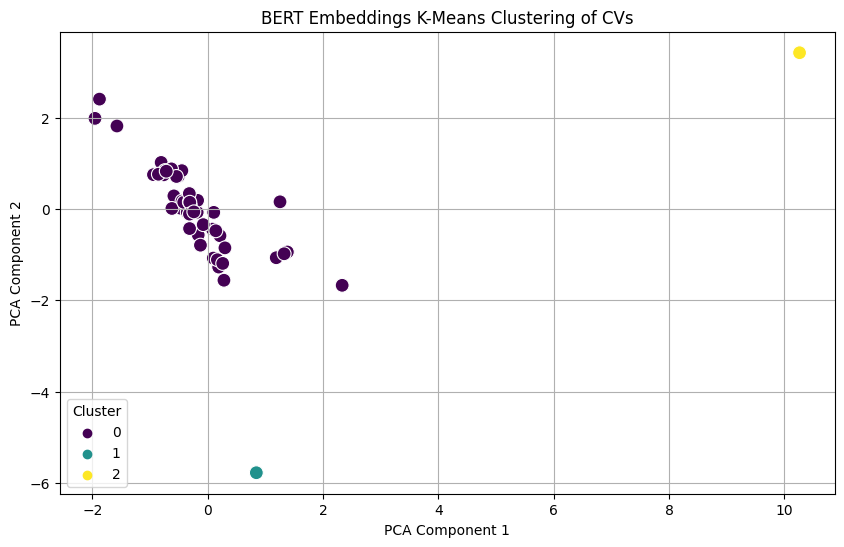

    Cluster
0         0
1         2
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
30        0
31        0
32        0
33        0
34        0
35        0
36        0
37        0
38        0
39        0
40        0
41        0
42        0
43        0
44        0
45        0
46        0
47        0
48        0
49        1


In [28]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming BERT embeddings have been extracted as in your code
# X_bert contains the embeddings for resumes

# Step 1: Perform K-Means Clustering (choose the number of clusters)
num_clusters = 3  # Adjust this based on the variety in your resumes
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_resumes['Cluster'] = kmeans.fit_predict(X_bert)

# Step 2: Dimensionality reduction using PCA for visualization (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_bert)

# Step 3: Add PCA components to the DataFrame for visualization
df_resumes['PCA1'] = X_pca[:, 0]
df_resumes['PCA2'] = X_pca[:, 1]

# Step 4: Visualization of clusters with PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_resumes, palette='viridis', legend='full', s=100)
plt.title('BERT Embeddings K-Means Clustering of CVs')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

# Optional: Print the clustered resumes (without 'filename' if it's missing)
print(df_resumes[['Cluster']])



#  Complex model

In [1]:
import pandas as pd
import numpy as np
import PyPDF2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
# Sample DataFrame of candidates 
data = {
    "Name": [
        "Alice Johnson", "Bob Smith", "Charlie Rose", "David Wilson", "Eva Adams", 
        "Franklin Lee", "Grace Thomas", "Hannah Brown", "Isaac Miller", "Julia Clark", 
        "Kevin Davis", "Laura Scott", "Michael Taylor", "Nina Martin", "Oliver White", 
        "Patricia Harris", "Quentin Lewis", "Rachel Moore", "Steven Carter", "Tina Lopez",
        "Ursula Nelson", "Victor Green", "Wendy King", "Xavier Hall", "Yasmine Brooks",
        "Zachary Sanders"
    ],
    "Email": [
        "alice@example.com", "bob@example.com", "charlie@example.com", "david@example.com", "eva@example.com", 
        "franklin@example.com", "grace@example.com", "hannah@example.com", "isaac@example.com", "julia@example.com", 
        "kevin@example.com", "laura@example.com", "michael@example.com", "nina@example.com", "oliver@example.com", 
        "patricia@example.com", "quentin@example.com", "rachel@example.com", "steven@example.com", "tina@example.com",
        "ursula@example.com", "victor@example.com", "wendy@example.com", "xavier@example.com", "yasmine@example.com",
        "zachary@example.com"
    ],
    "Skills": [
        "Python, Machine Learning, Data Analysis", 
        "Project Management, Agile, Scrum", 
        "Java, Spring Boot, Microservices", 
        "React, JavaScript, Frontend Development", 
        "SQL, Database Management, Data Warehousing",
        "Cloud Computing, AWS, DevOps",
        "Cybersecurity, Network Security, Risk Management",
        "UI/UX Design, Adobe XD, Figma", 
        "Kubernetes, Docker, CI/CD", 
        "Big Data, Hadoop, Spark",
        "Data Science, R, Python", 
        "Mobile App Development, Android, iOS", 
        "Blockchain, Solidity, Smart Contracts", 
        "Digital Marketing, SEO, SEM", 
        "Business Analysis, Requirements Gathering, Process Improvement",
        "Embedded Systems, C++, Robotics",
        "AI, Natural Language Processing, Deep Learning", 
        "Game Development, Unity, C#", 
        "Salesforce, CRM, Customer Success", 
        "Human Resources, Talent Acquisition, Training",
        "IT Support, Troubleshooting, Networking", 
        "Supply Chain Management, Logistics, ERP", 
        "Public Relations, Corporate Communications, Branding", 
        "Healthcare Management, HIPAA, Electronic Health Records",
        "Finance, Investment Banking, Risk Analysis", 
        "Legal Research, Contract Law, Litigation"
    ],
    "Education": [
        "MIT, Computer Science", 
        "Stanford, MBA", 
        "Harvard, Software Engineering", 
        "UC Berkeley, Electrical Engineering", 
        "Columbia, Data Science", 
        "University of Chicago, Cloud Computing", 
        "Carnegie Mellon, Cybersecurity", 
        "Parsons, Graphic Design", 
        "University of Washington, Systems Engineering", 
        "Cornell, Big Data Analytics", 
        "UCLA, Statistics", 
        "Duke University, Mobile Computing", 
        "Princeton, Cryptography", 
        "NYU, Digital Marketing", 
        "Wharton, Business Administration", 
        "Georgia Tech, Robotics Engineering", 
        "Oxford, Artificial Intelligence", 
        "University of Southern California, Game Development", 
        "Yale, Business Management", 
        "University of Texas, Human Resources", 
        "Purdue, IT Support", 
        "Michigan State, Supply Chain Management", 
        "Boston University, Communications", 
        "Johns Hopkins, Healthcare Administration", 
        "University of Pennsylvania, Finance", 
        "Georgetown, Law"
    ],
    "Experience": [
        "5 years in software development", 
        "8 years in project management", 
        "6 years in backend development", 
        "4 years in frontend development", 
        "7 years in database management", 
        "9 years in cloud infrastructure", 
        "10 years in cybersecurity", 
        "3 years in UI/UX design", 
        "5 years in DevOps engineering", 
        "6 years in big data analytics", 
        "4 years in data science", 
        "5 years in mobile development", 
        "7 years in blockchain development", 
        "6 years in digital marketing", 
        "8 years in business analysis", 
        "5 years in robotics engineering", 
        "4 years in AI research", 
        "6 years in game development", 
        "9 years in CRM and customer success", 
        "8 years in human resources management", 
        "7 years in IT support", 
        "10 years in supply chain logistics", 
        "6 years in corporate communications", 
        "7 years in healthcare administration", 
        "9 years in finance and risk management", 
        "5 years in legal research and litigation"
    ]
}


# Convert the data into a DataFrame
df = pd.DataFrame(data)

In [5]:
# Function to extract text from PDF (Job Description)
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page in reader.pages:
            text += page.extract_text()
    return text

# Load the job description from PDF

job_description_pdf = "job_description.pdf"
job_description = extract_text_from_pdf(job_description_pdf)

# Combine the candidate information into a single text field
df['Resume_Text'] = df['Skills'] + ". " + df['Education'] + ". " + df['Experience']


In [6]:
from sentence_transformers import SentenceTransformer, util

# Load pre-trained SBERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # You can try larger models for better accuracy

# Convert resumes and job description into SBERT embeddings
corpus = df['Resume_Text'].tolist()
corpus.append(job_description)  # Append job description for comparison

# Create embeddings for the entire corpus
corpus_embeddings = model.encode(corpus, convert_to_tensor=True)

# Extract job description embedding (last in the list)
job_embedding = corpus_embeddings[-1]
resume_embeddings = corpus_embeddings[:-1]  # All resume embeddings

# Define keywords to look for in resumes (extracted from the job description)
keywords_skills = ["Python", "Machine Learning", "Data Analysis"]  # Example skill keywords
keywords_education = ["Computer Science", "MIT", "Stanford"]  # Example education keywords
keywords_experience = ["software development", "project management"]  # Example experience keywords

# Function to count keyword matches in each resume
def count_keyword_matches(text, keywords):
    return sum(1 for keyword in keywords if keyword.lower() in text.lower())

# Apply keyword matching for skills, education, and experience in resumes
df['Skill_Matches'] = df['Resume_Text'].apply(lambda text: count_keyword_matches(text, keywords_skills))
df['Education_Matches'] = df['Resume_Text'].apply(lambda text: count_keyword_matches(text, keywords_education))
df['Experience_Matches'] = df['Resume_Text'].apply(lambda text: count_keyword_matches(text, keywords_experience))

# Normalize keyword match counts (optional: scale values between 0 and 1 for better combination)
df['Skill_Matches'] = df['Skill_Matches'] / max(df['Skill_Matches'].max(), 1)
df['Education_Matches'] = df['Education_Matches'] / max(df['Education_Matches'].max(), 1)
df['Experience_Matches'] = df['Experience_Matches'] / max(df['Experience_Matches'].max(), 1)

# Compute cosine similarity using SBERT embeddings
df['Similarity_Score'] = util.pytorch_cos_sim(resume_embeddings, job_embedding).cpu().numpy().flatten()

# Combine the keyword match scores with cosine similarity using weights
# Adjust the weights based on importance (e.g., 70% cosine similarity, 30% keyword match score)
df['Weighted_Score'] = (0.7 * df['Similarity_Score'] +
                        0.1 * df['Skill_Matches'] +
                        0.1 * df['Education_Matches'] +
                        0.1 * df['Experience_Matches'])

# Sort candidates by the new weighted score (highest to lowest)
df_sorted_sbert_weighted = df.sort_values(by='Weighted_Score', ascending=False)


# Print sorted candidates by SBERT similarity score
print(df_sorted_sbert_weighted[['Name', 'Email', 'Weighted_Score']])



c:\Python310\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


c:\Python310\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


               Name                 Email  Weighted_Score
0     Alice Johnson     alice@example.com        0.572844
1         Bob Smith       bob@example.com        0.490815
19       Tina Lopez      tina@example.com        0.332684
4         Eva Adams       eva@example.com        0.304212
9       Julia Clark     julia@example.com        0.301749
14     Oliver White    oliver@example.com        0.283267
18    Steven Carter    steven@example.com        0.262778
10      Kevin Davis     kevin@example.com        0.254271
13      Nina Martin      nina@example.com        0.214657
21     Victor Green    victor@example.com        0.185651
11      Laura Scott     laura@example.com        0.179903
3      David Wilson     david@example.com        0.175555
15  Patricia Harris  patricia@example.com        0.165302
22       Wendy King     wendy@example.com        0.153557
24   Yasmine Brooks   yasmine@example.com        0.151688
16    Quentin Lewis   quentin@example.com        0.149003
2      Charlie